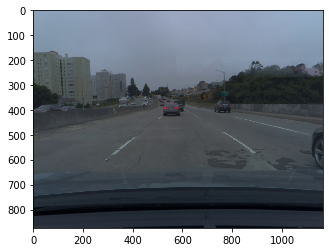

In [2]:
from matplotlib.pyplot import imshow
import numpy as np
import cv2 as cv

%matplotlib inline
frame = cv.imread('../frames/farme_0401.jpg')
frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
imshow(frame)

In [64]:
src = np.array([[300,600],[420,500],[780,500], [900, 600]], np.float32)
dst = np.array([[300,600],[300,500],[900,500], [900, 600]], np.float32)
H = cv.getPerspectiveTransform(src, dst)
H

array([[-7.14285714e-01, -1.71428571e+00,  1.02857143e+03],
       [ 0.00000000e+00, -2.14285714e+00,  8.57142857e+02],
       [-3.94745964e-19, -2.85714286e-03,  1.00000000e+00]])

In [76]:
intristics = np.array([[910.0, 0,     582.0],
                       [0,     910.0, 437.0],
                       [0,     0,     1.0]])

ground_from_medmodel_frame = np.array([[ 0.00000000e+00, 0.00000000e+00,  1.00000000e+00],
                                      [-1.09890110e-03, 0.00000000e+00,  2.81318681e-01],
                                      [-1.84808520e-20, 9.00738606e-04, -4.28751576e-02]])

extrinsic_matrix = np.array([[1., 0., 0., 0.],
                             [0., 1., 0., 0.],
                             [0., 0., 1., 0.]]) 

kernel = intristics.dot(ground_from_medmodel_frame)
#kernel = np.delete(kernel, 2, axis=1)
kernel / kernel[2,2]

array([[ 2.50864521e-16, -1.22268908e+01, -2.06424118e+04],
       [ 2.33235295e+01, -9.18067228e+00, -5.53382353e+03],
       [ 4.31038695e-19, -2.10084034e-02,  1.00000000e+00]])

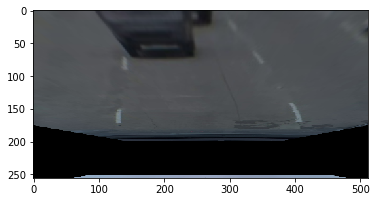

In [93]:
warp = cv.warpPerspective(frame, H, (1164,874))
model = cv.resize(warp, (512,256))
imshow(model)

In [94]:
model = cv.cvtColor(model, cv.COLOR_BGR2YUV)
model.shape

(256, 512, 3)

In [114]:
y, u, v = model[:,:,0], model[:,:,1], model[:,:,2]

In [128]:
y0 = y[0::2,0::2].astype(np.float32) / 255
y1 = y[1::2,0::2].astype(np.float32) / 255
y2 = y[0::2,1::2].astype(np.float32) / 255
y3 = y[1::2,1::2].astype(np.float32) / 255
u = cv.resize(u, (256, 128)).astype(np.float32) / 255
v = cv.resize(v, (256, 128)).astype(np.float32) / 255


In [134]:
tensor = np.array([y0, y1, y2, y3, u, v])

In [136]:
tensor.size

196608